In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm


import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# VECTOR AUTO REGRESSION EQUATION:


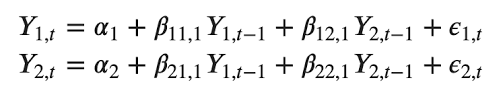

In [5]:
btc = yf.Ticker('BTC-USD')
ltc = yf.Ticker('LTC-USD')
eth = yf.Ticker('ETH-USD')

btc_hist = btc.history(period='max')
ltc_hist = ltc.history(period='max')
eth_hist = eth.history(period='max')

btc_his_res = btc_hist.reset_index()[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
ltc_his_res = ltc_hist.reset_index()[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
eth_his_res = eth_hist.reset_index()[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

btc_recol = btc_his_res.rename(columns=lambda x: f'BTC_{x}' if x != 'Date' else x)
ltc_recol = ltc_his_res.rename(columns=lambda x: f'LTC_{x}' if x != 'Date' else x)
eth_recol = eth_his_res.rename(columns=lambda x: f'ETH_{x}' if x != 'Date' else x)

# btc_recol.columns, ltc_recol.columns, eth_recol.columns

# Merge all into a master dataframe
master = pd.merge(btc_recol, ltc_recol, on='Date', how='outer')
master = pd.merge(master, eth_recol, on='Date', how='outer')

# Sort by Date
master = master.sort_values('Date')

# full_date_range = pd.date_range(start=master['Date'].min(), end=master['Date'].max(), freq='D')
# master = pd.DataFrame({'Date': full_date_range}).merge(master, on='Date', how='left')
master = master.fillna(0)

test_ratio = 0.1
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(master))
test_size = int(test_ratio * len(master))
print(f"train_size: {train_size}")
print(f"test_size: {test_size}")

train = master[:train_size]
test = master[train_size:]

master = master.set_index('Date')
master.head()

train_size: 3478
test_size: 386


,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume
Date,,,,,,,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,5.08589,5.17077,4.96595,5.05855,3071840,0.0,0.0,0.0,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,5.06543,5.06543,4.57996,4.68523,4569260,0.0,0.0,0.0,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,4.68729,4.75582,4.25435,4.32777,3917450,0.0,0.0,0.0,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,4.32920,4.61608,4.20219,4.28644,5490660,0.0,0.0,0.0,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,4.26307,4.30013,4.15499,4.24592,2931220,0.0,0.0,0.0,0.0,0.0


In [7]:
len(master.columns)

15

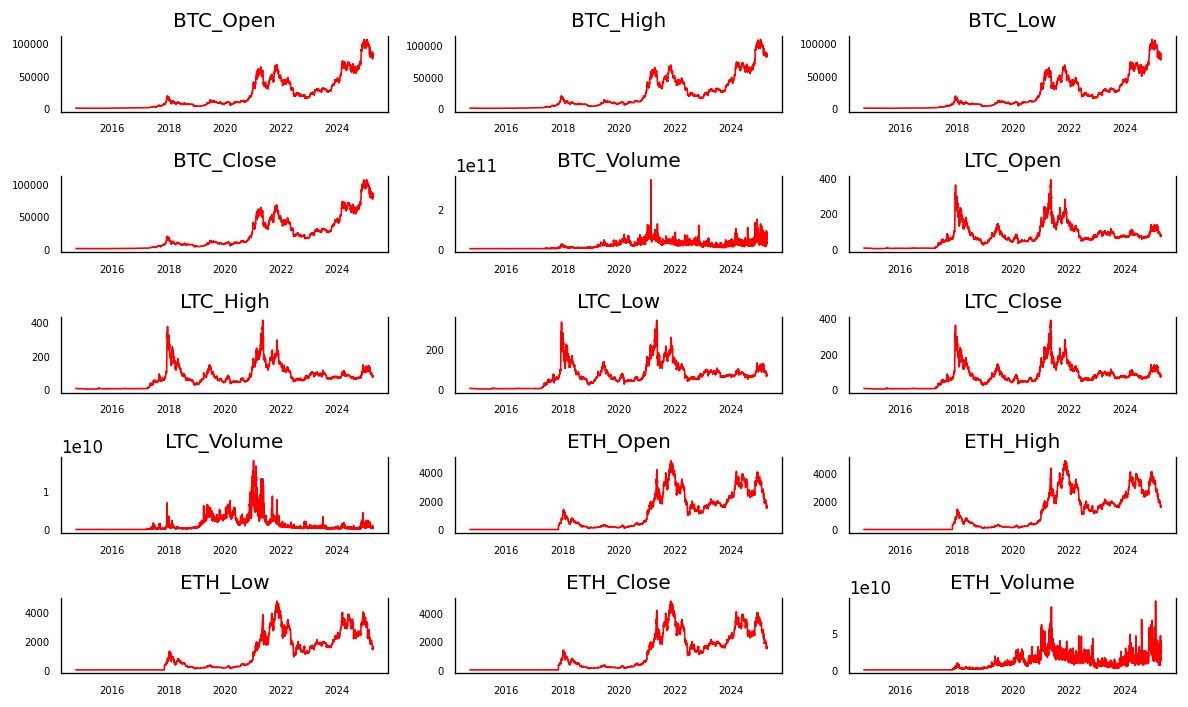

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = master[master.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(master.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [12]:
macro_data = master[['BTC_Close', 'LTC_Close', 'ETH_Close']]

In [15]:
ad_fuller_result_1 = adfuller(macro_data['BTC_Close'].diff()[1:])

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['LTC_Close'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(macro_data['ETH_Close'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

realgdp
ADF Statistic: -9.209581438419224
p-value: 1.903716173808528e-15

---------------------

realcons
ADF Statistic: -11.88780664848554
p-value: 5.966063807328158e-22

---------------------

realcons
ADF Statistic: -9.407648373367998
p-value: 5.951573936348404e-16


In [25]:
macro_data

,BTC_Close,LTC_Close,ETH_Close
Date,,,
2014-09-17 00:00:00+00:00,457.334015,5.058550,0.000000
2014-09-18 00:00:00+00:00,424.440002,4.685230,0.000000
2014-09-19 00:00:00+00:00,394.795990,4.327770,0.000000
2014-09-20 00:00:00+00:00,408.903992,4.286440,0.000000
2014-09-21 00:00:00+00:00,398.821014,4.245920,0.000000
...,...,...,...
2025-04-12 00:00:00+00:00,85287.109375,78.596924,1643.528564
2025-04-13 00:00:00+00:00,83684.976562,77.784248,1596.685791
2025-04-14 00:00:00+00:00,84542.390625,77.076431,1622.769897


In [ ]:
print('Btc cause Ltc?\n')
print('------------------')
granger_3 = grangercausalitytests(macro_data[['LTC_Close', 'BTC_Close']], 10)

print('\nBtc cause Eth?\n')
print('------------------')
granger_6 = grangercausalitytests(macro_data[['ETH_Close', 'BTC_Close']], 10)

print('\nLtc cause Btc?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_data[['BTC_Close', 'LTC_Close']], 10)

print('\nLtc cause Etc?\n')
print('------------------')
granger_5 = grangercausalitytests(macro_data[['ETH_Close', 'LTC_Close']], 10)


print('\nEth causes Ltc?\n')
print('------------------')
granger_4 = grangercausalitytests(macro_data[['LTC_Close', 'ETH_Close']], 10)

print('\nEth cause Btc?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_data[['BTC_Close', 'ETH_Close']], 10)

Btc cause Ltc?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5034  , p=0.1137  , df_denom=3861, df_num=1
ssr based chi2 test:   chi2=2.5054  , p=0.1135  , df=1
likelihood ratio test: chi2=2.5045  , p=0.1135  , df=1
parameter F test:         F=2.5034  , p=0.1137  , df_denom=3861, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1693  , p=0.1144  , df_denom=3858, df_num=2
ssr based chi2 test:   chi2=4.3442  , p=0.1139  , df=2
likelihood ratio test: chi2=4.3417  , p=0.1141  , df=2
parameter F test:         F=2.1693  , p=0.1144  , df_denom=3858, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1006  , p=0.0980  , df_denom=3855, df_num=3
ssr based chi2 test:   chi2=6.3132  , p=0.0973  , df=3
likelihood ratio test: chi2=6.3081  , p=0.0975  , df=3
parameter F test:         F=2.1006  , p=0.0980  , df_denom=3855, df_num=3

Granger Causality
number of lags (no zero) 4
ssr bas

In [18]:
print(macro_data.shape)

(3865, 3)


In [19]:
train_df=macro_data[:-30]
test_df=macro_data[-30:]

In [20]:
print(test_df.shape)

(30, 3)


In [32]:
train_df = train_df[['LTC_Close', 'ETH_Close', 'BTC_Close']]

In [33]:
model = VAR(train_df.diff()[1:])

In [35]:
sorted_order=model.select_order(maxlags=10)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        24.57      24.57*   4.671e+10       24.57
1        24.56       24.58   4.645e+10       24.57
2        24.56       24.60   4.655e+10       24.58
3        24.56       24.61   4.650e+10       24.58
4        24.56       24.62   4.626e+10       24.58
5        24.55       24.62   4.571e+10       24.57
6        24.53       24.62   4.483e+10       24.56
7        24.52       24.63   4.469e+10       24.56
8        24.52       24.64   4.456e+10       24.56
9        24.50       24.64   4.384e+10       24.55
10      24.50*       24.65  4.359e+10*      24.55*
--------------------------------------------------


In [36]:
var_model = VARMAX(train_df, order=(10,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                      Statespace Model Results                                     
Dep. Variable:     ['LTC_Close', 'ETH_Close', 'BTC_Close']   No. Observations:                 3835
Model:                                             VAR(10)   Log Likelihood             -422769.957
                                               + intercept   AIC                         845737.915
Date:                                     Wed, 16 Apr 2025   BIC                         846356.855
Time:                                             19:50:01   HQIC                        845957.783
Sample:                                         09-17-2014                                         
                                              - 03-17-2025                                         
Covariance Type:                                       opg                                         
Ljung-Box (L1) (Q):     3705.02, 3657.95, 3723.34   Jarque-Bera (JB):   1535.51, 699.53, 593.26
Prob

In [ ]:
n_forecast = 30
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)

predictions=predict.predicted_mean
predictions.columns = 

In [47]:
test_df.head()

,BTC_Close,LTC_Close,ETH_Close
Date,,,
2025-03-18 00:00:00+00:00,82718.500000,90.082695,1932.543457
2025-03-19 00:00:00+00:00,86854.226562,94.050446,2057.749023
2025-03-20 00:00:00+00:00,84167.195312,93.282623,1982.099854
2025-03-21 00:00:00+00:00,84043.242188,90.933357,1964.847534
2025-03-22 00:00:00+00:00,83832.484375,91.257545,1980.037842


In [48]:
predictions.columns=['LTC_Close', 'ETH_Close', 'BTC_Close']
predictions.head()

,LTC_Close,ETH_Close,BTC_Close
2025-03-18 00:00:00+00:00,77.560068,1698.266613,77129.077321
2025-03-19 00:00:00+00:00,82.500153,1720.069768,77865.628350
2025-03-20 00:00:00+00:00,86.004940,1738.141297,77484.673128
2025-03-21 00:00:00+00:00,85.371766,1743.171666,76873.429919
2025-03-22 00:00:00+00:00,85.418384,1705.138097,75439.473106


In [49]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<Axes: >

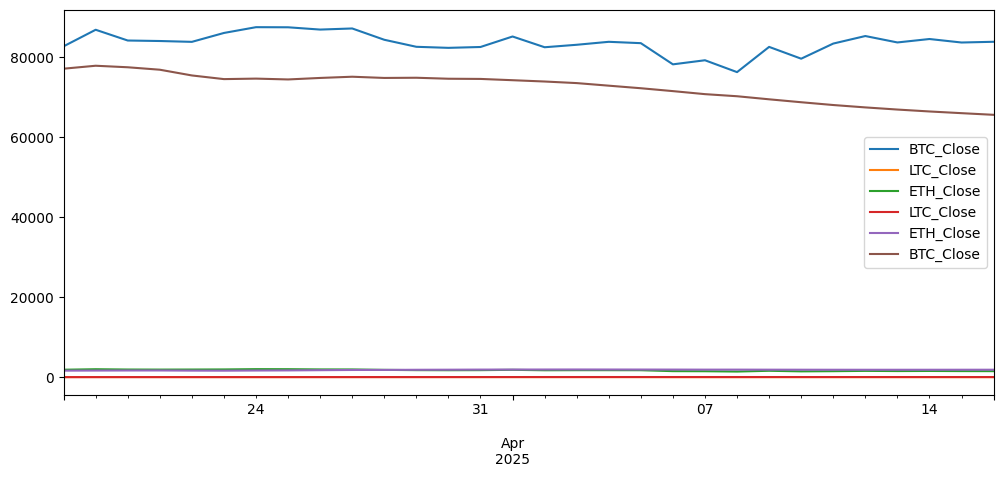

In [50]:
test_vs_pred.plot(figsize=(12,5))

In [52]:
test_df.shape

(30, 3)

In [55]:
test_df.head()

,BTC_Close,LTC_Close,ETH_Close
Date,,,
2025-03-18 00:00:00+00:00,82718.500000,90.082695,1932.543457
2025-03-19 00:00:00+00:00,86854.226562,94.050446,2057.749023
2025-03-20 00:00:00+00:00,84167.195312,93.282623,1982.099854
2025-03-21 00:00:00+00:00,84043.242188,90.933357,1964.847534
2025-03-22 00:00:00+00:00,83832.484375,91.257545,1980.037842


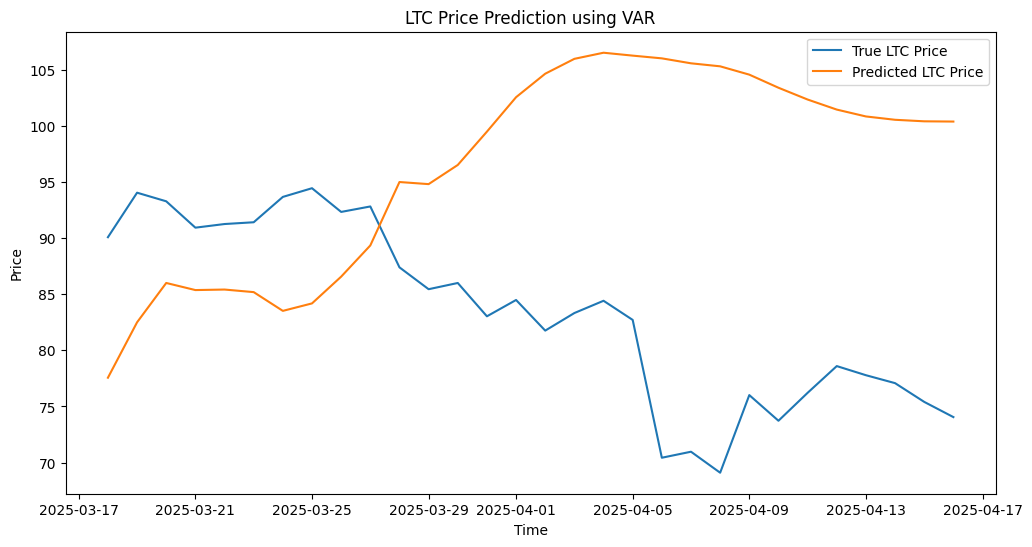

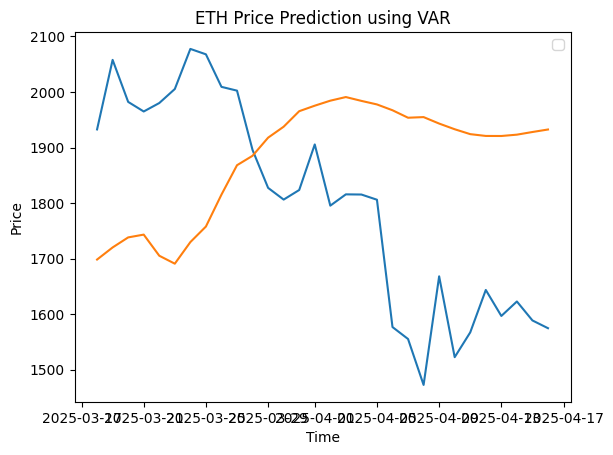

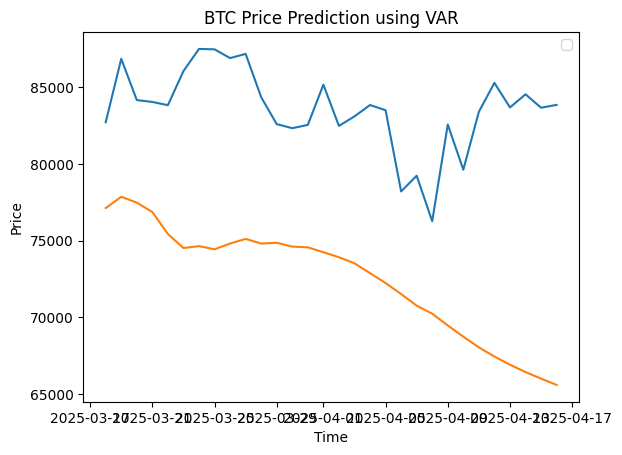

In [56]:
plt.figure(figsize=(12,6))
plt.plot(test_df['LTC_Close'], label='True LTC Price')
plt.plot(predictions['LTC_Close'], label='Predicted LTC Price')
plt.title("LTC Price Prediction using VAR")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
plt.plot(test_df['ETH_Close'])
plt.plot(predictions['ETH_Close'])
plt.title("ETH Price Prediction using VAR")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
plt.plot(test_df['BTC_Close'])
plt.plot(predictions['BTC_Close'])
plt.title("BTC Price Prediction using VAR")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


Mean value of ULC is : 178.56666666666666. Root Mean Squared Error is :54.906898811679284
Mean value of RGNP is : 3970.6916666666666. Root Mean Squared Error is :345.3434852726223
